In [ ]:
%pip install pandas
%pip install matplotlib
%pip install haversine

In [2]:
from os import listdir
from sys import version_info
from math import isnan
from typing import TypedDict, Literal
from pandas import read_csv, DataFrame
from matplotlib import pyplot
from haversine import Unit, haversine

In [3]:
# Must have python 3.10 or above to run the next cell otherwise skip it
assert version_info >= (3, 10)

Defines what `data` looks like, it will be a dictionary of dictionaries.

In [4]:
'''
{
	'close_car': {
		'Bandwidth': data,
		'Frequency': data,
		'SpreadingFactor': data,
		'TxPower': data,
	},
	'close_noCar': {
		'Bandwidth': data,
		'Frequency': data,
		'SpreadingFactor': data,
		'TxPower': data,
	},
	'far_car': {
		'Bandwidth': data,
		'Frequency': data,
		'SpreadingFactor': data,
		'TxPower': data,
	},
	'far_noCar': {
		'Bandwidth': data,
		'Frequency': data,
		'SpreadingFactor': data,
		'TxPower': data,
	},
}
'''

Distance = Literal['close'] | Literal['far']
Car = Literal['car'] | Literal['noCar']
Settings = Literal[f'{Distance}_{Car}']
Params = Literal['Bandwidth'] | Literal['Frequency'] | Literal['SpreadingFactor'] | Literal['TxPower']

class Params(TypedDict):
	Params: DataFrame

class Data(TypedDict):
	Settings: Params

### Data collection and cleaning

In [5]:
def calculate_distance(df: DataFrame) -> DataFrame:
    dist = {'Distance': []}
    for x in df.index:
        # any abnormal distance means the GPS data has been corrupted
        try:
            receiver_lat = float(df["R_Lat"][x])
            receiver_long = float(df["R_Long"][x])

            sender_lat = float(df["S_Lat"][x])
            sender_long =  float(df["S_Long"][x])
        except ValueError:
            continue

        loc1 = (receiver_lat,receiver_long)
        loc2 = (sender_lat,sender_long)

        distance = round(haversine(loc1,loc2,unit=Unit.METERS),2)
        if distance > 90 or distance < 1:
            continue

        dist["Distance"].append(distance)
    return DataFrame(dist)

In [6]:
data: Data = {}
names = ['Time','Number','S_Lat','S_Long','Bandwidth','CodingRate','Frequency','SpreadingFactor','TxPower','PacketRSSI','RSSI','SNR','R_Lat','R_Long']
for csv in listdir():
	if csv.endswith('csv'):
		skiprows = []
		with open(csv) as f:
			i = 0
			for line in f.readlines():
				if len(line.split(',')) != len(names):
					skiprows.append(i)
				i += 1
		# skip any row that does not have the right number of columns
		df = read_csv(csv, header=None, names=names, skiprows=skiprows)
		# set receiver coordinates to a fixed latitude and longitude if it is 0 as the GPS was unable to collect the data
		df.loc[df['R_Lat'] == 0, 'R_Lat'] = -31.977475
		df.loc[df['R_Long'] == 0, 'R_Long'] = 115.816291
		df = df.assign(Distance=calculate_distance(df))
		# store it in the dictionary
		settings = csv.split('_')
		setting = '_'.join(settings[:2])
		param = settings[2].split('.')[0]
		if setting in data:
			data[setting][param] = df
		else:
			data[setting] = {param: df}

In [7]:
def plot(ylabel: str):
	'''
	for each setting where the experiment was conducted plot one of the link quality metrics against different Lora parameters for all the data point collected.
	'''
	for setting, params in data.items():
		i = 1
		figure = pyplot.figure(figsize=(20,5))
		distance = 0
		for param, item in sorted(params.items()):
			distance += item['Distance'].mean()
			pyplot.subplot(1, 4, i)
			powers = []
			for tx, df in item.groupby(param)[ylabel]:
				if (i == 1):
					pyplot.ylabel(ylabel)
				df.plot(xlabel='Number', title=param)
				powers.append(tx)
			pyplot.gca().legend(powers)
			i += 1
		figure.suptitle(f'{setting}: {round(distance / 4)} meters')

### Visualisation

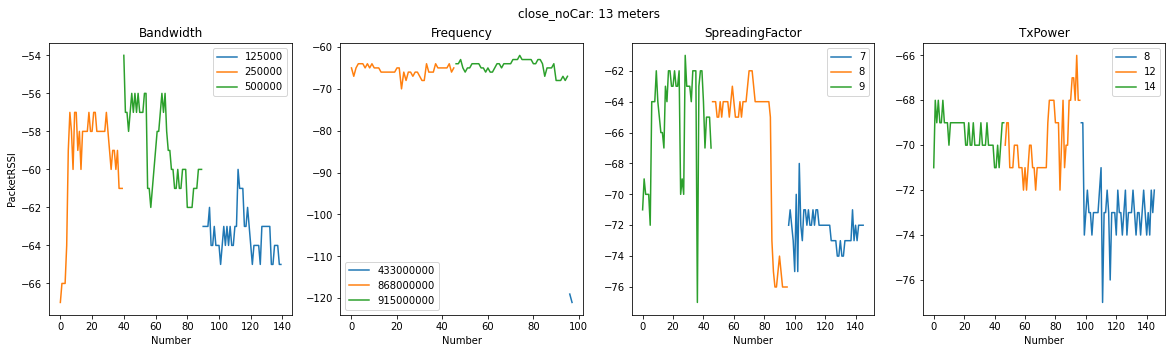

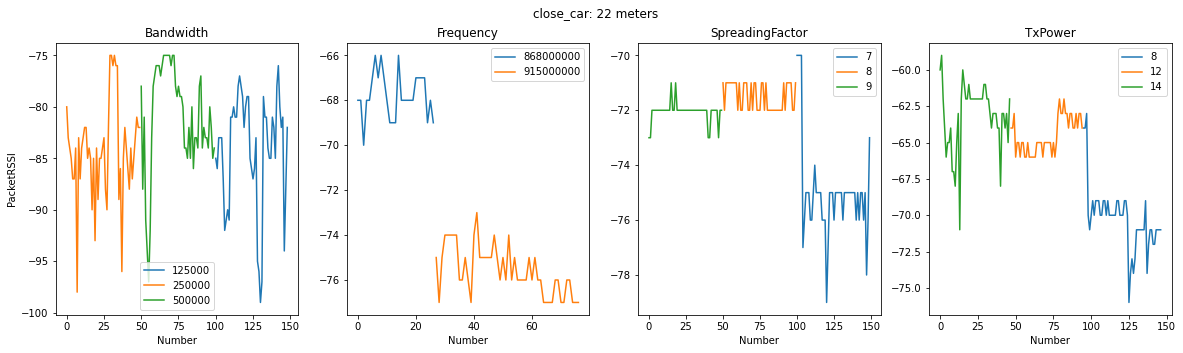

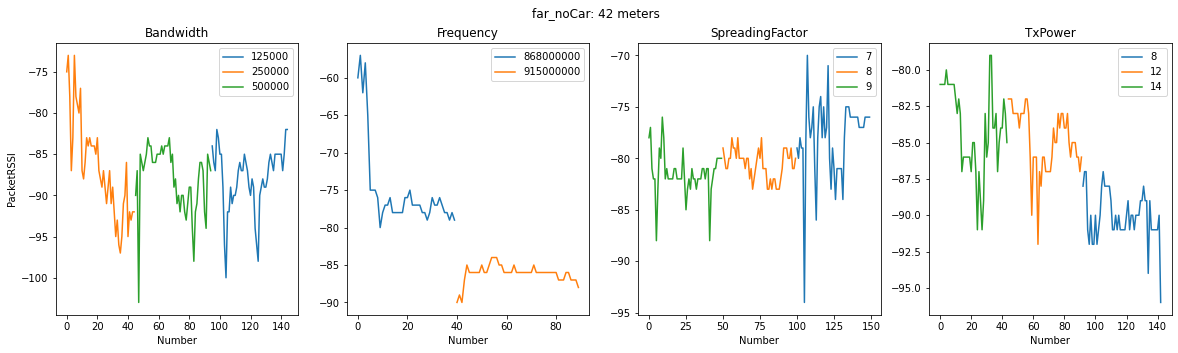

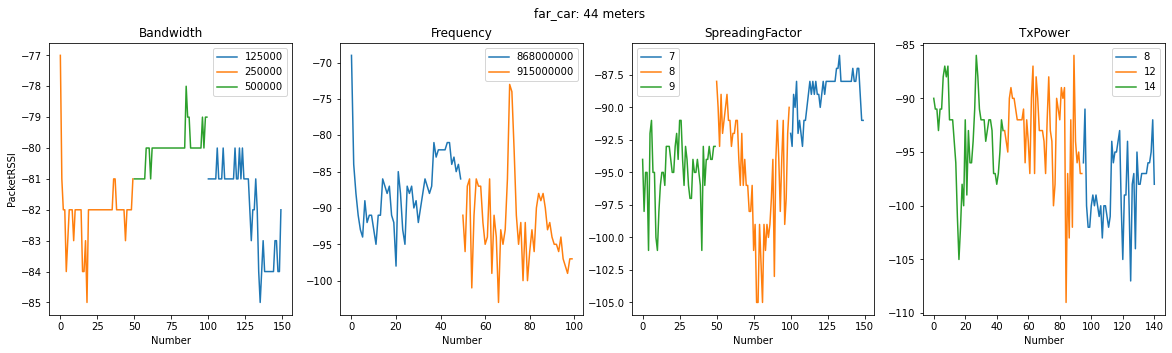

In [8]:
plot('PacketRSSI')

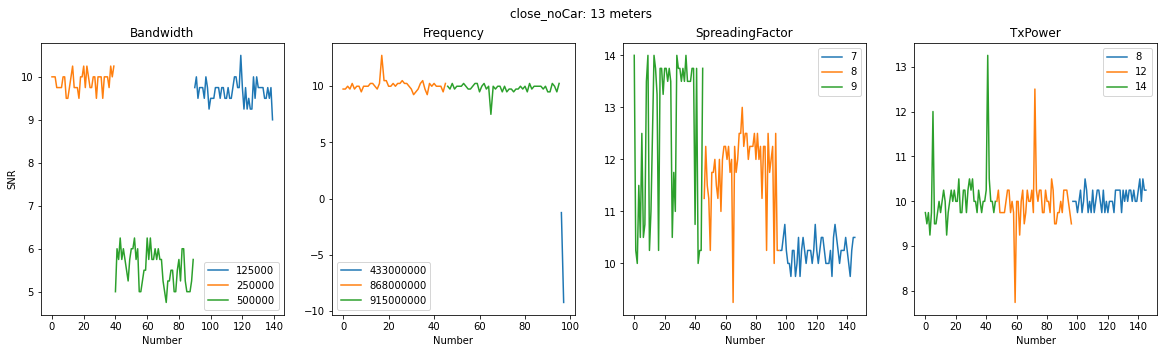

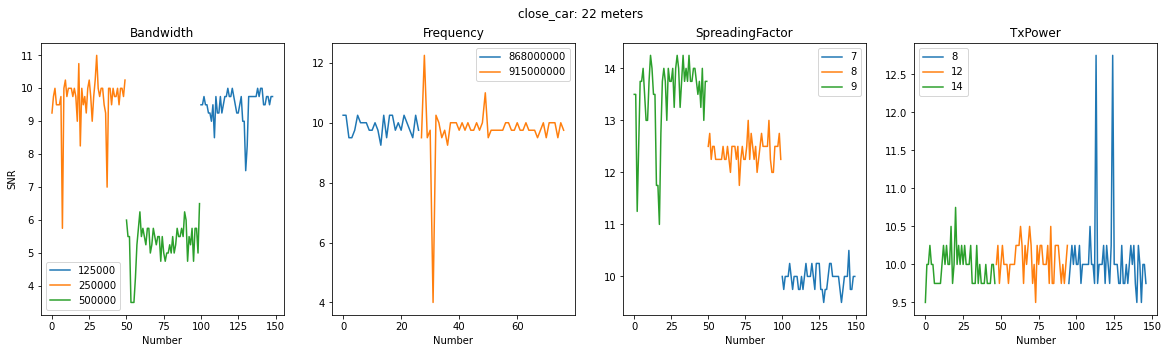

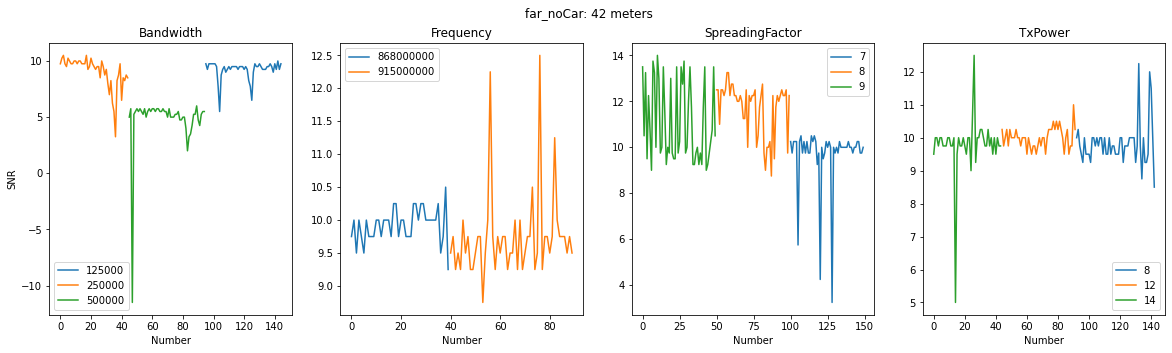

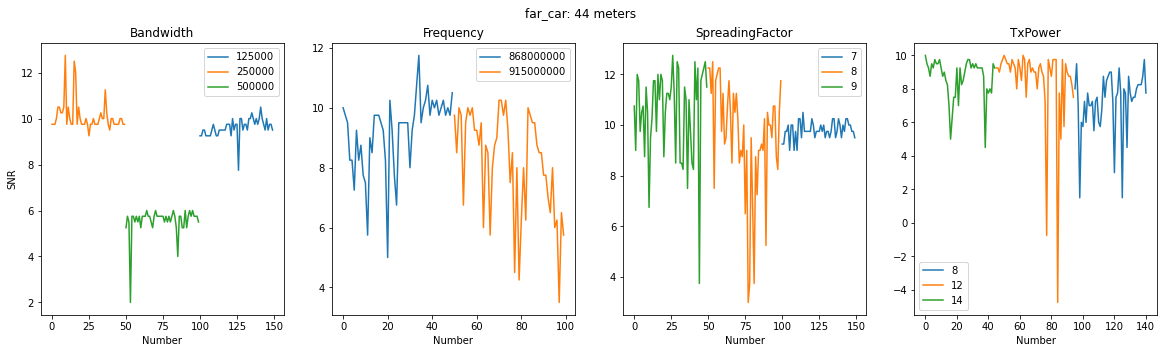

In [9]:
plot('SNR')